In [ ]:
## Installing required dependencies
# !pip install nba_api
# !pip install scipy
# !pip install pycaret

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#ML import libraries
from pycaret.regression import *

#Libraries for pre and post processing
import pandas as pd
import numpy as np
import os
import os.path
import time
import json
import requests


#NBA api imports for data collection
import nba_api
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import cumestatsplayer
from nba_api.stats.endpoints import cumestatsplayergames
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import SeasonAll


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction


In This jupyer notebook I will be trying to predict NBA players performane based on their previous seasons of play. For the purpose of simplicity I will be retrieving the data from Lebron James.

The first step in this notebook will be to import all the relevent statistics on every active player in the NBA. This is achieved by using the nba_api, a wrapper that interacts with the NBA official stats api.

In [ ]:
#get active players list
active_players = players.get_active_players()

In [ ]:
#function that retrieves a players stats from 2021-2023
def get_player_season_stats(player_id,full_name):
  gamelog_player = pd.concat(playergamelog.PlayerGameLog(player_id=player_id, season=SeasonAll.all).get_data_frames())
  gamelog_player["GAME_DATE"] = pd.to_datetime(gamelog_player["GAME_DATE"], format="%b %d, %Y")
  gamelog_player = gamelog_player.query("GAME_DATE.dt.year in [2021, 2022,2023]")
  print('finished importing df for ' + full_name)
  return gamelog_player

In [ ]:
# Dictionary to store DataFrames
dataframes = {}
df_names = []

# Loop through the players and create a DataFrame for each player
for player in active_players:
    player_id = player['id']
    full_name = player['full_name'].replace(' ', '_')
    df_names.append(f'df_{full_name}')
    dataframes[f'df_{full_name}'] = get_player_season_stats(player_id,full_name)

In [ ]:
# Loop through each DataFrame in the dictionary
for name, df in dataframes.items():
    # Drop the specified columns, inplace=True modifies the DataFrame in place
    df.drop(["VIDEO_AVAILABLE", "SEASON_ID", "Player_ID", "Game_ID"], axis=1, inplace=True)


# ML with pycaret

The pycaret library is contains useful functions to help you streamline different ML models and compare the errors against each other using cross validation to output the best model based on the training set provided.

In [ ]:
#We isolate lebron from the dictionary of dataframes in the previous cells. We will be using this as our data set
df_lebron = dataframes['df_LeBron_James']

In [ ]:
#Some information about the columns provided.
df_lebron.info()

In [ ]:
#After some trial and error, these are the features that don't cause data leakage on this specific data set. This can change
#depending on the player.

feat = ['PTS','GAME_DATE','MATCHUP','MIN','FGM','FGA','FG3M','FG3A','REB','AST','STL','BLK','TOV','PF']

In [ ]:
#Setup the regression framework via pycaret. Session_id =42 relates to the seed value to be replicated.
regr = setup(data = df_lebron[feat], target = 'PTS', session_id=42)

,Description,Value
0,Session id,42
1,Target,PTS
2,Target type,Regression
3,Original data shape,"(158, 14)"
4,Transformed data shape,"(158, 16)"
5,Transformed train set shape,"(110, 16)"
6,Transformed test set shape,"(48, 16)"
7,Numeric features,11
8,Date features,1
9,Categorical features,1


In [ ]:
#This cell tests the different models done by the setup and picks the best model based on cross validation and error.
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.1082,7.8881,2.7442,0.8342,0.0905,0.0751,0.0960
en,Elastic Net,2.2170,8.1574,2.7844,0.8311,0.0943,0.0810,0.1430
lasso,Lasso Regression,2.2143,8.1276,2.7851,0.8265,0.0945,0.0807,0.1410
llar,Lasso Least Angle Regression,2.2143,8.1281,2.7852,0.8264,0.0945,0.0807,0.0700
br,Bayesian Ridge,2.3247,9.3392,2.9715,0.8114,0.1008,0.0849,0.0710
ridge,Ridge Regression,2.4113,10.1674,3.0921,0.7977,0.1053,0.0885,0.1330
lr,Linear Regression,2.4230,10.2889,3.1095,0.7957,0.1059,0.0890,0.5790
gbr,Gradient Boosting Regressor,2.5030,10.3362,3.1712,0.7855,0.1149,0.0964,0.2240
et,Extra Trees Regressor,2.4777,10.1400,3.1046,0.7837,0.1137,0.0957,0.3490
rf,Random Forest Regressor,2.5162,10.8970,3.2422,0.7735,0.1165,0.0958,0.2470


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
#This cell provides an interactive way to visually inspect the different components that have gone into the model
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Feature importance plot

This feature importance plot is interesting in several ways.



*   FGM and FG3M are intuitively linked to points made which makes sense.
*   Matchup comes up next but is surprising based on the weight of its importance. One would assume that other features would carry more weight.
*   These features only provide significant signals within this training set and maybe subject to change based on other player statistics.





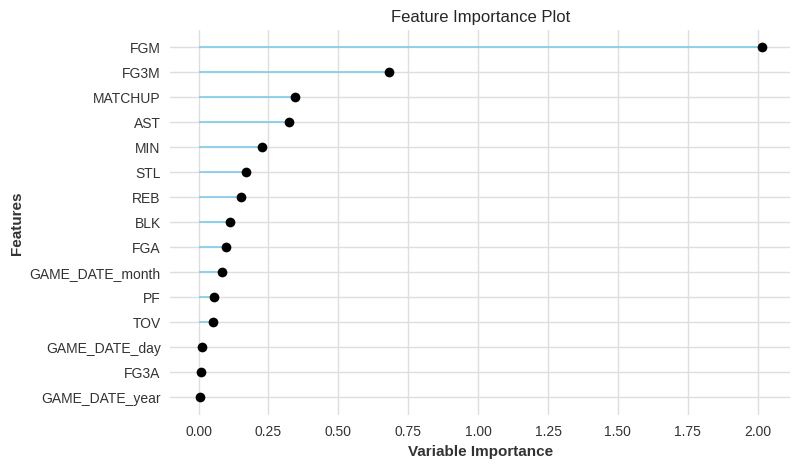

In [ ]:
plot_model(best, plot = 'feature_all')

# Residual plot

The residual plot is not too extreme when it comes to Lebron's consistency. We can see fringe outliers when the predicted value increases over 30. One way to interpret this would be that Lebron on any given night would average anywhere between 20-30 points with a deviation of +-4.

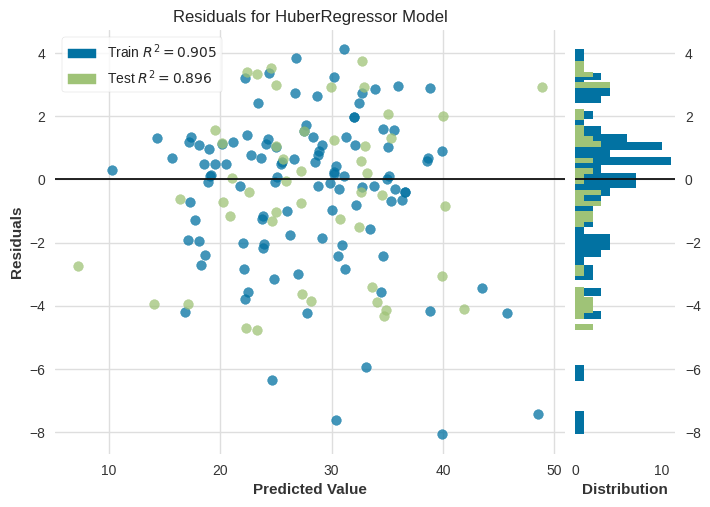

In [ ]:
plot_model(best, plot = 'residuals')

# Error plot

The line of best fit here behaves linearly which is a good sign. Although the R2 value is at a 0.896. There is room for improvement here when dealing with predictions that require errors that don't exceed an absolute value of one. Furthermore, the model maybe overfitting the training data due to lack of other signals such as teammates, opponents, and lack of injury/load management data.

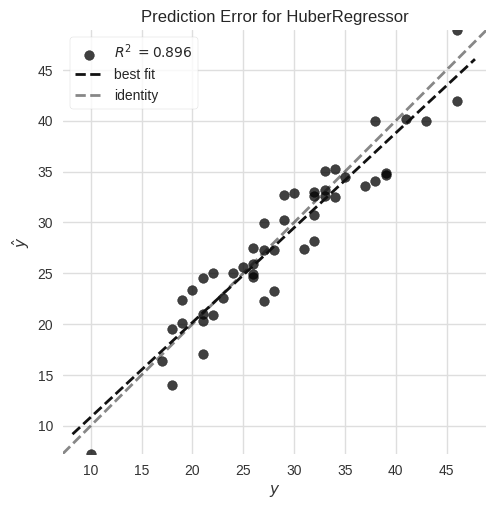

In [ ]:
plot_model(best, plot = 'error')

# Hyper parameters

The model has decided that these hyper parameters have fit the model best.

In [ ]:
plot_model(best, plot = 'parameter')

,Parameters
alpha,0.0001
epsilon,1.35
fit_intercept,True
max_iter,100
tol,1e-05
warm_start,False


# Predictions

Below is the predicted dataframe with points as the target variable. We can see that there are wild swings in the prediction for certain games, but those that are close are usually <1.

This can be worrying when dealing with line bets and where line points are marked halfway through the average of a players points scored within x amount of games.

In [ ]:
predict_model(best).sort_values(['GAME_DATE'],ascending = False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.1133,6.5621,2.5617,0.8958,0.1010,0.0794


,GAME_DATE,MATCHUP,MIN,FGM,FGA,FG3M,FG3A,REB,AST,STL,BLK,TOV,PF,PTS,prediction_label
9,2023-04-05,LAL @ LAC,35,13,20,4,6,8,7,1,1,6,0,33,33.191729
12,2023-03-31,LAL @ MIN,32,7,19,1,3,10,6,1,2,3,1,18,19.558795
15,2023-02-26,LAL @ DAL,37,10,23,1,6,8,3,1,1,3,4,26,27.520133
18,2023-02-07,LAL vs. OKC,34,13,20,4,6,7,3,3,0,4,3,38,34.120166
19,2023-02-04,LAL @ NOP,40,10,22,1,7,9,6,0,0,2,2,27,27.253572
22,2023-01-28,LAL @ BOS,44,15,30,6,12,9,8,0,0,2,2,41,40.163375
24,2023-01-24,LAL vs. LAC,33,16,29,9,14,8,7,2,1,0,0,46,41.907540
26,2023-01-20,LAL vs. MEM,37,8,21,1,5,9,6,2,2,3,4,23,22.600753
29,2023-01-15,LAL vs. PHI,35,15,23,1,5,8,10,1,1,3,1,35,34.508073
30,2023-01-12,LAL vs. DAL,47,9,28,0,7,16,9,2,0,3,0,24,25.043313


# What comes next?

This is just the first step in building a more accurate prediction model for future games. The current setup has weaknesses such as:



*   Lack of other player data that may contribute to predicted points (e.g. Anthony Davis being injured may yield Lebron More points).
*   Non-clustered/bucketed categorical data to enhance accuracy. This current model has no way of classifying players based on teams, if they're on the starting lineup, or if teammates play a role in team synergy.
*   Unsupervised training sets. Intuitively when splitting datasets, randomness is good practice for reducing overfitting. However, when dealing with infrequent time series data such as the NBA, certain validation techniques such as walk forward validation would need to be used to enhance model accuracy.




# Betting predictions:

Once a model that is trained to be more indicative of predicting values within an arbritraily set error margin, We would need to apply betting strategies such as the [Kelly Criterion](https://https://en.wikipedia.org/wiki/Kelly_criterion).


# Contact:

For more information on the progress of my project, please feel free to reach out to me at my email: Johnnynbis98@gmail.com